In [1]:
from doe_modules.simulation import Test4

In [2]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from doe_modules.preferences import kwarg_savefig

In [3]:
from itertools import product

In [4]:
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

In [5]:
from doe_modules.design import CLOO

In [6]:
# models = [Prototype(v, model_id=i) for i, v in enumerate(edges)]
models = [Test4(v, model_id=i) for i, v in enumerate(edges)]

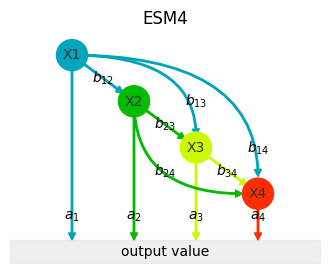

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))
model = Test4(edges[-1], model_id="")
model.plot(ax)

datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

for i in [1, 2, 3, 4]:
    ax.text(
        datdot.h[i - 1], 2,
        r"$a_{" + str(i) + "}$",
        ha="center", va="center", size=10
    )

for k, b in b_pos.items():
    ax.text(
        *b_pos[k], r"$b_{" + str(k) + "}$",
        ha="center", va="center", size=10
    )

ax.set(title=model.name)

fig.savefig(f"/home/jovyan/out/test4_models.pdf", **kwarg_savefig)

In [8]:
ap = lambda c: dict(
    shrink=0, width=1, headwidth=5, 
    headlength=5, connectionstyle="arc3",
    facecolor=c, edgecolor=c,
)

ap2 = lambda c: dict(
    arrowstyle="|-|", connectionstyle="arc3",
    facecolor=c, edgecolor=c,
    linewidth=2, mutation_scale=4,
)

angleA = lambda n: [0, -90, 0, -45][n - 1]
angleB = lambda n: [90, 180, 105, 120][n - 1]

app = lambda n, c: dict(
    shrink=0, width=1, headwidth=5, 
    headlength=5, 
    connectionstyle=f"angle3, angleA={angleA(n)}, angleB={angleB(n)}",
    facecolor=c, edgecolor=c,
)

apn = lambda n, c: dict(
    arrowstyle="|-|", connectionstyle=f"angle3, angleA={angleA(n)}, angleB={angleB(n)}",
    facecolor=c, edgecolor=c,
    linewidth=2, mutation_scale=4,
)

arrconf=dict(ha="center", va="center", zorder=-10)

edge_pos = {
    12: ([datdot.h[1] - .5 / np.sqrt(2), datdot.v[1] + .5 / np.sqrt(2)], [datdot.h[0], datdot.v[0]]),
    13: ([datdot.h[2], datdot.v[2] + .5], [datdot.h[0], datdot.v[0]]),
    14: ([datdot.h[3], datdot.v[3] + .75], [datdot.h[0], datdot.v[0]]),
    23: ([datdot.h[2] - .5 / np.sqrt(2), datdot.v[2] + .5 / np.sqrt(2)], [datdot.h[1], datdot.v[1]]),
    24: ([datdot.h[3] - .5, datdot.v[3]], [datdot.h[1], datdot.v[1]]),
    34: ([datdot.h[3] - .5 / np.sqrt(2), datdot.v[3] + .5 / np.sqrt(2)], [datdot.h[2], datdot.v[2]]),
}

In [9]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": ["r", "r", ".9", "r"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: ((datdot.h[2] + datdot.h[1:3].mean()) / 2, (datdot.v[1] + datdot.v[1:3].mean()) / 2),
    14: (datdot.h[3], datdot.v[2]),
}

a_aps = {
    2: ap("r"),
    4: ap2("r")
}

b_aps = {
    12: ap("r"),
    13: app(1, ".9"),
    14: apn(1, "r"),
    23: ap2(".9"),
}

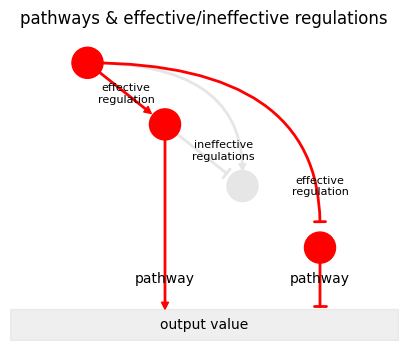

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[2 - 1], 1], [datdot.h[2 - 1], datdot.v[2 - 1]], arrowprops=a_aps[2], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[2 - 1], 2, "pathway", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], 2, "pathway", ha="center", va="center", size=10)

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[23], arrowprops=b_aps[23], **arrconf)

ax.text(*b_pos[12], "effective\nregulation", ha="center", va="center", size=8)
ax.text(*b_pos[13], "ineffective\nregulations", ha="center", va="top", size=8)
ax.text(*b_pos[14], "effective\nregulation", ha="center", va="center", size=8)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("pathways & effective/ineffective regulations")

fig.savefig(f"/home/jovyan/out/feat_path_reg.pdf", **kwarg_savefig)

In [11]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": [".9", ".9", ".9", ".9"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap(".9"),
    2: ap(".9"),
    3: ap2(".9"),
    4: ap2(".9")
}

b_aps = {
    12: ap(".9"),
    13: app(1, ".9"),
    14: apn(1, ".9"),
    23: ap2(".9"),
    24: app(2, ".9"),
}

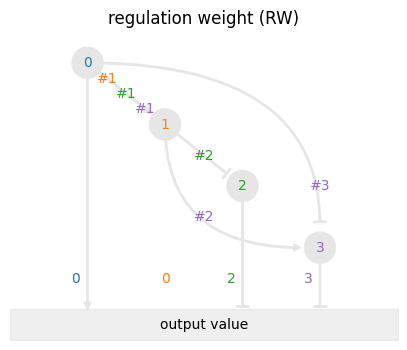

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "0", ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "1", ha="center", va="center", size=10, c="C1")
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "2", ha="center", va="center", size=10, c="C2")
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "3", ha="center", va="center", size=10, c="C4")

ax.text(datdot.h[1 - 1] -.3, 2, "0", ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10, c="C1")
ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10, c="C2")
ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[23], arrowprops=b_aps[23], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)

ax.text(*(np.array(b_pos[12])+np.array([-.5, .5])), "#1", ha="center", va="center", size=10, c="C1")
ax.text(*(np.array(b_pos[12])+np.array([-0, 0])), "#1", ha="center", va="center", size=10, c="C2")
ax.text(*(np.array(b_pos[12])+np.array([.5, -.5])), "#1", ha="center", va="center", size=10, c="C4")
ax.text(*b_pos[14], "#3", ha="center", va="center", size=10, c="C4")
ax.text(*b_pos[23], "#2", ha="center", va="center", size=10, c="C2")
ax.text(*b_pos[24], "#2", ha="center", va="center", size=10, c="C4")

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("regulation weight (RW)")

fig.savefig(f"/home/jovyan/out/feat_reg_weight.pdf", **kwarg_savefig)

In [13]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": ["r", "r", ".9", "r"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap(".9"),
    2: ap(".9"),
    3: ap2(".9"),
    4: ap2("r")
}

b_aps = {
    12: ap(".9"),
    13: app(1, ".9"),
    14: apn(1, "r"),
    23: ap2(".9"),
    24: app(2, "r"),
}

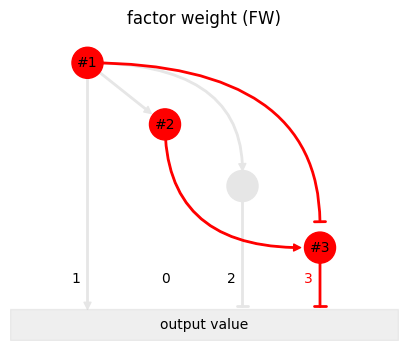

In [14]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "#1", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "#2", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "#3", ha="center", va="center", size=10)

ax.text(datdot.h[1 - 1] -.3, 2, "1", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="r")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)

ax.text(*b_pos[12], "", ha="center", va="center", size=10)
ax.text(*b_pos[13], "", ha="center", va="center", size=10)
ax.text(*b_pos[14], "", ha="center", va="center", size=10)
ax.text(*b_pos[24], "", ha="center", va="center", size=10)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("factor weight (FW)")

fig.savefig(f"/home/jovyan/out/feat_factor_weight.pdf", **kwarg_savefig)

In [15]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": [".9", ".9", ".9", ".9"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap("C0"),
    2: ap(".9"),
    3: ap("C1"),
    4: ap2("C2")
}

b_aps = {
    12: ap("C2"),
    13: app(1, "C1"),
    14: apn(1, "C4"),
    23: ap2(".9"),
    24: app(2, "C2"),
}

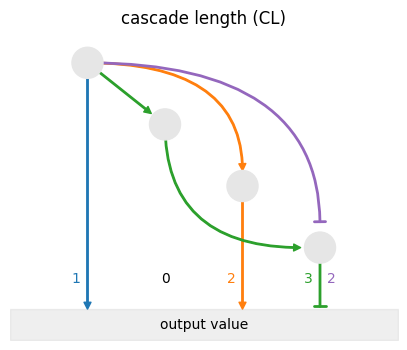

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "", ha="center", va="center", size=10)

ax.text(datdot.h[1 - 1] -.3, 2, "1", ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10, c="C1")
ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="C2")
ax.text(datdot.h[4 - 1] +.3, 2, "2", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)

ax.text(*b_pos[12], "", ha="center", va="center", size=10)
ax.text(*b_pos[13], "", ha="center", va="center", size=10)
ax.text(*b_pos[14], "", ha="center", va="center", size=10)
ax.text(*b_pos[24], "", ha="center", va="center", size=8)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("cascade length (CL)")

fig.savefig(f"/home/jovyan/out/feat_cascade_length.pdf", **kwarg_savefig)

In [17]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": ["r", "r", "r", "r"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap("C0"),
    2: ap(".9"),
    3: ap("C1"),
    4: ap2(".9")
}

b_aps = {
    12: ap("C2"),
    13: app(1, "C1"),
    14: apn(1, "C0"),
    23: ap2(".9"),
    24: app(2, "C1"),
    34: ap("C2"),
}

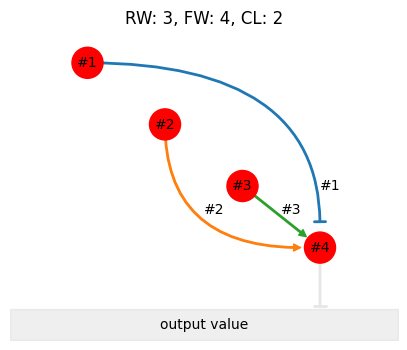

In [18]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "#1", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "#2", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "#3", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "#4", ha="center", va="center", size=10)

# ax.text(datdot.h[1 - 1] -.3, 2, "1", ha="center", va="center", size=10, c="C0")
# ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
# ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10, c="C1")
# ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="C2")
# ax.text(datdot.h[4 - 1] +.3, 2, "2", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)
ax.annotate("", *edge_pos[34], arrowprops=b_aps[34], **arrconf)

ax.text(*b_pos[14], "#1", ha="left", va="center", size=10)
ax.text(*b_pos[24], "#2", ha="left", va="bottom", size=10)
ax.text(*b_pos[34], "#3", ha="left", va="bottom", size=10)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("RW: 3, FW: 4, CL: 2")

fig.savefig(f"/home/jovyan/out/feat_rw_vs_fw_vs_cl.pdf", **kwarg_savefig)

In [19]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": [".9", ".9", ".9", ".9"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap("C0"),
    2: ap2(".9"),
    3: ap("C0"),
    4: ap2("C1")
}

b_aps = {
    12: ap("C1"),
    13: app(1, "C0"),
    14: apn(1, ".9"),
    23: ap2(".9"),
    24: app(2, "C1"),
    34: ap("C2"),
}

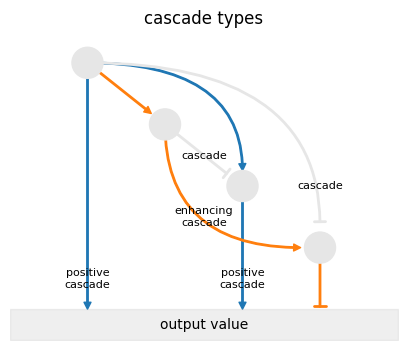

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
# ax.annotate("", [datdot.h[2 - 1], 1], [datdot.h[2 - 1], datdot.v[2 - 1]], arrowprops=a_aps[2], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

# ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "0", ha="center", va="center", size=10)
# ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "0", ha="center", va="center", size=10)
# ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "0", ha="center", va="center", size=10)
# ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "3", ha="center", va="center", size=10)

ax.text(datdot.h[1 - 1], 2, "positive\ncascade", ha="center", va="center", size=8)
# ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], 2, "positive\ncascade", ha="center", va="center", size=8)
# ax.text(datdot.h[4 - 1], 2, "positive\ncascade", ha="center", va="center", size=8)
# ax.text(datdot.h[4 - 1] +.3, 2, "2", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[23], arrowprops=b_aps[23], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)
# ax.annotate("", *edge_pos[34], arrowprops=b_aps[34], **arrconf)

# ax.text(*b_pos[12], "0+1", ha="center", va="center", size=10)
# ax.text(*b_pos[13], "positive\ncascade", ha="center", va="center", size=8)
ax.text(*b_pos[14], "cascade", ha="center", va="center", size=8)
ax.text(*b_pos[23], "cascade", ha="center", va="center", size=8)
ax.text(*b_pos[24], "enhancing\ncascade", ha="center", va="center", size=8)
# ax.text(*b_pos[34], "0+1", ha="center", va="center", size=10)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("cascade types")

fig.savefig(f"/home/jovyan/out/feat_cascade_types.pdf", **kwarg_savefig)

In [21]:
from doe_modules.preferences import textcolor

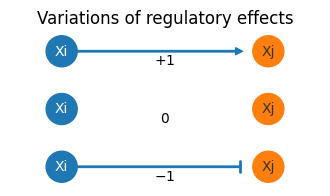

In [22]:
fig, ax = plt.subplots(figsize=(4, 2))

datdot = pd.DataFrame({
    "name": ["Xi", "Xj"] * 3,
    "h": [1, 5, 1, 5, 1, 5],
    "v": [9, 9, 6, 6, 3, 3],
    "c": [plt.cm.tab10(0), plt.cm.tab10(1)] * 3
})

ap = lambda n: dict(
    shrink=0, width=1, headwidth=5, 
    headlength=5, connectionstyle="arc3",
    facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1]
)
        
ap2 = lambda n: dict(
    arrowstyle="|-|", connectionstyle="arc3",
    facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
    linewidth=2, mutation_scale=4,
)

arrconf=dict(ha="center", va="center", zorder=-10)

ax.scatter(data=datdot, x="h", y="v", s=500, color="c")

ax.annotate("", [4.5, 9], [1, 9], arrowprops=ap(1), **arrconf)
ax.annotate("", [4.5, 3], [1, 3], arrowprops=ap2(1), **arrconf)

for i, name in enumerate(datdot.name):
    ax.text(
        datdot.h[i], datdot.v[i], name, 
        ha="center", va="center", size="medium",
        c=textcolor(datdot.c[i])
    )

ax.set_ylim([2, 10])
ax.set_xlim([0, 6])
ax.axis("off")

ax.text(3, 8.5, r"$+1$", ha="center", va="center", size=10)
ax.text(3, 5.5, r"$0$", ha="center", va="center", size=10)
ax.text(3, 2.5, r"$-1$", ha="center", va="center", size=10)

ax.set_title("Variations of regulatory effects")

fig.savefig(f"/home/jovyan/out/prototype_models_edges.pdf", **kwarg_savefig)

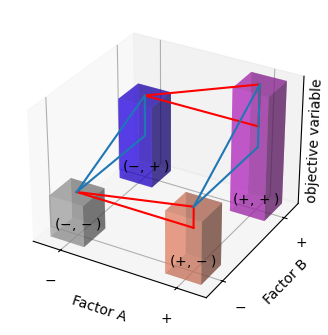

In [23]:
fig = plt.figure(figsize=(4, 4), facecolor="w")
ax = fig.add_subplot(111, projection="3d")

a = 2
b = 3
c = 4
d = 6

width = depth = .3
center = depth / 2

ax.bar3d(0, 0, 0, width, depth, a, shade=True, alpha=.5, color=".7")
ax.bar3d(1, 0, 0, width, depth, b, shade=True, alpha=.5, color=plt.cm.gnuplot2(.7))
ax.bar3d(0, 1, 0, width, depth, c, shade=True, alpha=.5, color=plt.cm.gnuplot2(.3))
ax.bar3d(1, 1, 0, width, depth, d, shade=True, alpha=.5, color=plt.cm.gnuplot2(.5))


ax.plot([0 + center, 1 + center], [0 + center, 0 + center], [a, b], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [0 + center, 0 + center], [a, a], c="r", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 0 + center], [a, b], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [1 + center, 1 + center], [c, d], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [1 + center, 1 + center], [c, c], c="r", zorder=10)
ax.plot([1 + center, 1 + center], [1 + center, 1 + center], [c, d], c="r", zorder=10)

ax.plot([0 + center, 0 + center], [0 + center, 1 + center], [a, c], c="C0", zorder=10)
ax.plot([0 + center, 0 + center], [0 + center, 1 + center], [a, a], c="C0", zorder=10)
ax.plot([0 + center, 0 + center], [1 + center, 1 + center], [a, c], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 1 + center], [b, d], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 1 + center], [b, b], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [1 + center, 1 + center], [b, d], c="C0", zorder=10)
# ax.plot([1 + center, 0 + center], [0 + center, 1 + center], [b, c], c=".5", zorder=10)

ax.set_xticks([0 + center, 1 + center], ["$-$", "$+$"])
ax.set_yticks([0 + center, 1 + center], ["$-$", "$+$"])
ax.set_zticks([], [])
ax.set_xlabel("Factor A", labelpad=-1)
ax.set_ylabel("Factor B", labelpad=0)
ax.set_zlabel("objective variable", labelpad=-15)

ax.text(0 + center, 0 + center, 0, "$(-,-)$", zorder=100, ha="center", va="bottom")
ax.text(1 + center, 0 + center, 0, "$(+,-)$", zorder=100, ha="center", va="bottom")
ax.text(0 + center, 1 + center, 0, "$(-,+)$", zorder=100, ha="center", va="bottom")
ax.text(1 + center, 1 + center, 0, "$(+,+)$", zorder=100, ha="center", va="bottom")

plt.show()

fig.savefig(f"/home/jovyan/out/multicomp_vs_anova.pdf", **kwarg_savefig)